In [164]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import random
import math

### Test dataset

- circle
- moon

In [5]:
circle = pd.read_csv('circle.txt', names=['x','y'])
moon = pd.read_csv('moon.txt', names=['x','y'])
circle.shape, moon.shape

((1500, 2), (1500, 2))

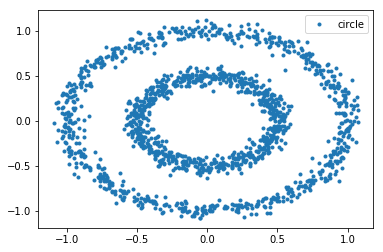

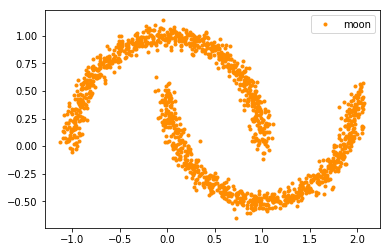

In [12]:
plt.plot(circle['x'], circle['y'],'.',label='circle')
plt.legend()
plt.show()
plt.plot(moon['x'], moon['y'],'.',c='darkorange',label='moon')
plt.legend()
plt.show()

### some common function

In [141]:
def showClustering(
    datas, 
    C,
    u=None,
    k=None, 
    color_k = ['blue', 'darkorange', 'green', 'deeppink']
):
    if k == None:
        k = len(C[0])
    
    plt.figure(figsize=(10,10))
    for i in range(k):
        if type(u) != type(None):
            plt.plot(u[i][0],u[i][1],'o',
                     c=color_k[i],
                     markersize=150.0, 
                     alpha=0.3
                    )
            plt.plot(u[i][0],u[i][1],'*',
                     c=color_k[i],
                     #markersize=150.0, 
                     alpha=0.3,
                     label='clustering {} mean'.format(i+1)
                    )
        clustering_datas = datas[C[:,i]==1,:]
        plt.plot(clustering_datas[:,0],clustering_datas[:,1],'.',c=color_k[i], label='clustering '+str(i+1))

    plt.legend()
    plt.show()

### K-means

In [170]:
def Euclidean(x,y):
    if len(x.shape)==1:
        x = x[None,:]
    if len(y.shape)==1:
        y = y[None,:]
    return np.matmul(x**2, np.ones((x.shape[1],y.shape[0]))) \
    + np.matmul(np.ones((x.shape[0],x.shape[1])), (y**2).T) \
    - 2*np.dot(x,y.T)

In [691]:
# initial setting
k = 2
data_source = np.array(circle)

# initial parameters
data_len = data_source.shape[0]
x_dims = data_source.shape[1]
u = [[random.random() for _ in range(x_dims)] for _ in range(k)]
#u = [[0.0 for _ in range(x_dims)] for _ in range(k)]
u = np.array(u)

#u = np.array([[0.01,-0.01],[-0.01,0.01]])

u

array([[0.54045413, 0.70107827],
       [0.6727411 , 0.01520782]])

In [698]:
# E-step
# w = len(data)*k
# c = len(data)*k (1 mean belong to this clustering)

w = np.matmul(data_source**2, np.ones((x_dims, k))) \
    + np.matmul(np.ones((data_len,x_dims)), (u**2).T) \
    - 2*np.dot(data_source, u.T)
#showClustering(data_source, c, u)

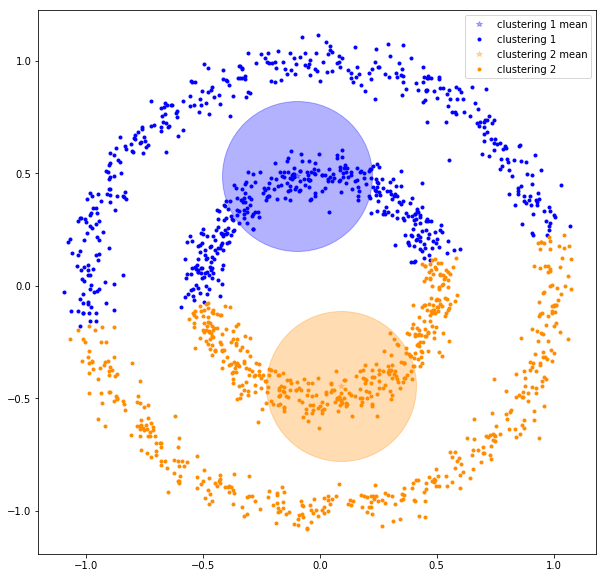

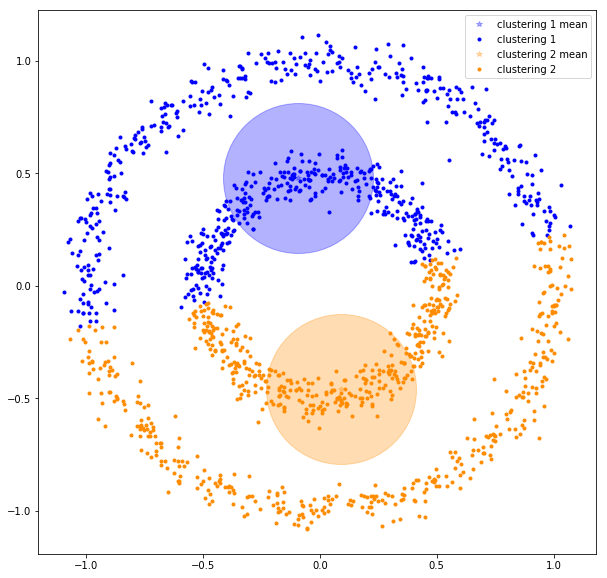

In [699]:
# M-step
# update u = k*x_dims

c = np.zeros(w.shape)
c[np.arange(w.shape[0]),np.argmin(w, axis=1)] = 1

u_update = np.matmul(c.T, data_source) / np.sum(c, axis=0)[:,None]

showClustering(data_source, c, u)

u = u_update


showClustering(data_source, c, u_update)

### kernel K-means

$$ \\
\min_{C_1...C_k} \sum_{i=1}^k\sum_{x_j \in C_i} || \phi(x_j) - u_i^\phi ||^2 \\
|| \phi(x_j) - u_k^\phi || = || k(x_j, x_j) - \frac{2}{|C_k|}\sum_n\alpha_{kn} k(x_j, x_n) + \frac{1}{|C_k|^2}\sum_p\sum_q\alpha_{kp}\alpha_{kq} k(x_p, x_q) ||
$$

rewrite to numpy format

- n : data length
- d : input dims
- k : clustering number

- D : data
    - n*d 
- C : whick clusering (1 mean belong this cluserting)
    - n*k
- k(D,D) : gram matrix
    - n*n
$$ \\
matmul(k(D,D)*eye(n),ones((n,k))) + -2*\frac{matmul(k(D,D),C)}{sum(C)} +  \frac{matmul(ones((n,k)),(C^Tk(D,D)C)*eye(k))}{sum(C)^2}
$$

In [413]:
def RBFkernel(gamma=1):
    return lambda u,v:np.exp(-1*gamma*Euclidean(u,v));

In [393]:
print(Euclidean(data_source,data_source)[:3,:3])
print(np.exp(-0.01*Euclidean(data_source,data_source))[:3,:3])

[[0.         3.38265098 1.98367734]
 [3.38265098 0.         0.18577108]
 [1.98367734 0.18577108 0.        ]]
[[1.         0.96673921 0.98035868]
 [0.96673921 1.         0.99814401]
 [0.98035868 0.99814401 1.        ]]


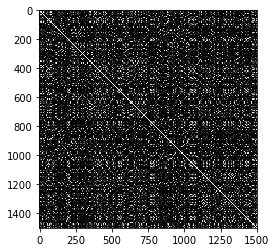

In [662]:
# initial setting
kernel = RBFkernel(5)
data_source = np.array(circle)
k = 2

# initial parameters
gram_matrix = kernel(data_source, data_source)
c = np.zeros((data_source.shape[0],k))
c[np.arange(c.shape[0]),np.random.randint(k,size=c.shape[0])] = 1

plt.imshow(gram_matrix, cmap='gray')

In [689]:
# E-step

w = np.matmul(
        gram_matrix * np.eye(data_source.shape[0]), 
        np.ones((data_source.shape[0], c.shape[1])) 
    ) \
    - 2*( np.matmul(gram_matrix, c) / np.sum(c, axis=0) ) \
    + (np.matmul(
        np.ones((data_source.shape[0], c.shape[1])), 
        np.matmul(np.matmul(c.T, gram_matrix), c)*np.eye(c.shape[1])
    ) / (np.sum(c,axis=0)**2) )
w = w**2

20


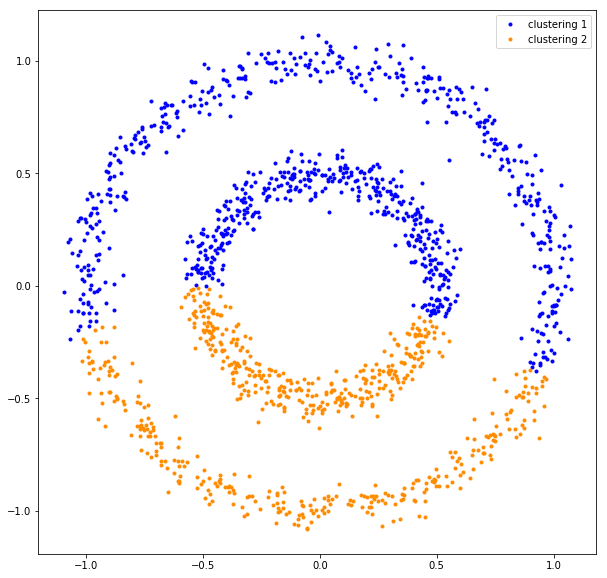

In [690]:
# M-step

update_c = np.zeros(w.shape)
update_c[np.arange(w.shape[0]),np.argmin(w, axis=1)] = 1

delta_c = np.count_nonzero(np.abs(update_c - c))

c = update_c

print(delta_c)

showClustering(data_source, update_c)

### spectral clustering